In [3]:
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

data_dir = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_train"

# Define transforms (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

print("Classes:", dataset.classes)

Classes: ['carcinoma_in_situ', 'light_dysplastic', 'moderate_dysplastic', 'normal_columnar', 'normal_intermediate', 'normal_superficiel', 'severe_dysplastic']


In [5]:
import cv2
import numpy as np
from skimage import measure, color

def extract_handcrafted_features(img):
    # img: numpy array (H, W, 3), BGR for OpenCV
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # morphological cleanup
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # label connected regions
    labels = measure.label(clean)
    props = measure.regionprops(labels)

    feats = []
    for prop in props:
        feats.append({
            'area': prop.area,
            'perimeter': prop.perimeter,
            'eccentricity': prop.eccentricity,
            'solidity': prop.solidity,
            'mean_intensity': prop.mean_intensity
        })
    return feats

In [7]:
import torch
from torchvision import models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load SqueezeNet and remove the last classifier
sqnet = models.squeezenet1_1(pretrained=True).to(device)
sqnet_features = torch.nn.Sequential(*list(sqnet.features.children()),
                                      sqnet.num_classes and sqnet.classifier[:1]) \
                    .to(device)

sqnet_features.eval()

# Extract features
all_features, all_labels = [], []

with torch.no_grad():
    for imgs, labels in loader:
        imgs = imgs.to(device)
        feats = sqnet_features(imgs)            # shape: (batch, num_features, H, W)
        feats = torch.nn.functional.adaptive_avg_pool2d(feats, (1,1))
        feats = feats.view(feats.size(0), -1)   # (batch, 512)
        all_features.append(feats.cpu().numpy())
        all_labels.append(labels.numpy())

all_features = np.vstack(all_features)
all_labels = np.concatenate(all_labels)

C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Placeholder: Flatten handcrafted features
hc_feats = np.random.rand(all_features.shape[0], 10)  # e.g., 10 handcrafted features

X = np.hstack([all_features, hc_feats])
y = all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale & train SVM
scaler = StandardScaler().fit(X_train)
X_train_scl, X_test_scl = scaler.transform(X_train), scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, probability=True).fit(X_train_scl, y_train)

print(classification_report(y_test, svm.predict(X_test_scl)))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       143
           1       0.88      0.87      0.88       125
           2       0.82      0.78      0.80       100
           3       0.94      0.88      0.91        68
           4       0.96      1.00      0.98        48
           5       1.00      0.96      0.98        50
           6       0.79      0.79      0.79       132

    accuracy                           0.87       666
   macro avg       0.89      0.89      0.89       666
weighted avg       0.87      0.87      0.87       666



In [9]:
# --- 3. Define GazelleOptimizer (from your code) ---
import numpy as np, torch
from torch.optim import Optimizer

def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    if np.random.rand() < prob_brownian:
        return np.random.normal(0, 0.1, size)
    else:
        sigma = (np.math.gamma(1+lam)*np.sin(np.pi*lam/2)/
                 (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)
        u = np.random.normal(0, sigma, size)
        v = np.random.normal(0, 1, size)
        return u / (np.abs(v)**(1/lam))

class GazelleOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, exploration_factor=0.1, num_gazelles=5, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum, exploration_factor=exploration_factor, num_gazelles=num_gazelles)
        super().__init__(params, defaults)
        self.num_gazelles = num_gazelles
        self.prob_brownian = prob_brownian
        self.gazelles = None

    def initialize_population(self, shape, device, dtype):
        return torch.randn((self.num_gazelles, *shape), device=device, dtype=dtype).clamp(-1,1)

    def step(self, closure=None):
        loss = closure() if closure else None
        for group in self.param_groups:
            lr, momentum, ef, ng = group['lr'], group['momentum'], group['exploration_factor'], group['num_gazelles']
            for p in group['params']:
                if p.grad is None: continue
                d = p.grad.data
                if self.gazelles is None or self.gazelles.shape[1:] != d.shape:
                    self.gazelles = self.initialize_population(d.shape, p.device, p.dtype)
                step_vec = torch.tensor(levy_brownian_step(self.prob_brownian, size=d.numel()),
                                        device=p.device, dtype=p.dtype).view_as(d)
                for i in range(ng):
                    self.gazelles[i] = (self.gazelles[i] + ef*step_vec).clamp(-1,1)
                elite = self.gazelles.mean(dim=0)
                buf = self.state[p].get('momentum_buffer')
                if buf is None:
                    buf = torch.clone(d).detach()
                    self.state[p]['momentum_buffer'] = buf
                else:
                    buf.mul_(momentum).add_(d)
                update = d if buf is None else buf
                p.data.add_(-lr, update + ef * elite)
        return loss

In [12]:
# --- 4. Model Setup & Training Preparation ---
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.squeezenet1_1(pretrained=True)
model.classifier[1] = nn.Conv2d(512, len(dataset.classes), kernel_size=1)
model.num_classes = len(dataset.classes)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = GazelleOptimizer(model.parameters(), lr=1e-4, momentum=0.9,
                             exploration_factor=0.05, num_gazelles=5, prob_brownian=0.3)

In [48]:
# ——— TRAINING LOOP ————————————————————————————————————————
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        def closure():
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            return loss

        loss = optimizer.step(closure)
        with torch.no_grad():
            preds = model(imgs).argmax(dim=1)
            total_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    train_loss = total_loss / len(loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

C:\Users\CVR\AppData\Local\Temp\ipykernel_9132\1825404067.py:9: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma = (np.math.gamma(1+lam)*np.sin(np.pi*lam/2)/
C:\Users\CVR\AppData\Local\Temp\ipykernel_9132\1825404067.py:10: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


In [52]:
# -------------------- VALIDATION --------------------
model.eval()
val_loss, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        preds = outputs.argmax(dim=1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
        val_total += labels.size(0)

val_loss /= len(loader)
val_acc = val_correct / val_total
val_losses.append(val_loss)
val_accuracies.append(val_acc)

print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%")


Epoch 20/20 Train Loss: 0.0393, Train Acc: 99.31% Val Loss: 0.0203, Val Acc: 99.43%


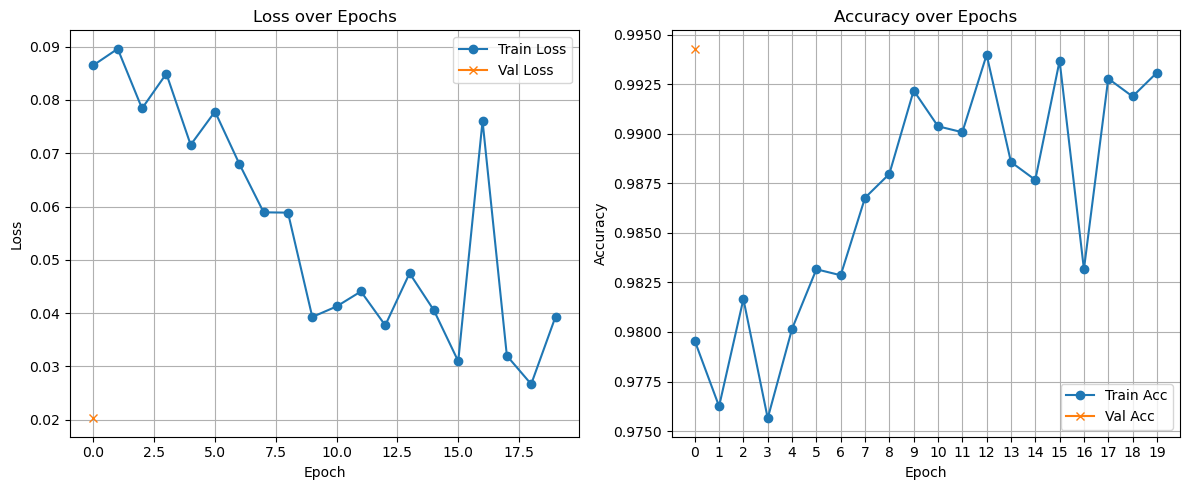

In [56]:
# -------------------- PLOT METRICS --------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='x')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc", marker='o')
plt.plot(val_accuracies, label="Val Acc", marker='x')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.xticks(range(num_epochs)) 
plt.show()


In [62]:



val_loss = 0.0
val_correct = 0
val_total = 0

model.eval()
with torch.no_grad():
    for val_imgs, val_labels in loader:
        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        val_outputs = model(val_imgs)
        val_loss = criterion(val_outputs, val_labels)
        val_loss_epoch += val_loss.item()
        _, predicted = torch.max(val_outputs.data, 1)
        val_total += val_labels.size(0)
        val_correct += (predicted == val_labels).sum().item()

val_losses.append(val_loss_epoch / len(loader))
val_accuracies.append(val_correct / val_total)


In [35]:
 # ---------- VALIDATION (on same loader for simplicity) ----------
model.eval()
val_loss, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)
        preds = out.argmax(dim=1)
        val_loss += loss.item()
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_losses.append(val_loss / len(loader))
val_accuracies.append(val_correct / val_total)

print(f"Epoch {epoch+1}/{num_epochs} – "
        f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% – "
        f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")

# Save best model
if val_accuracies[-1] > best_val_acc:
    best_val_acc = val_accuracies[-1]
    torch.save(model.state_dict(), "best_squeezenet_gazelle.pth")

print("\nBest Validation Accuracy:", best_val_acc * 100, "%")

Epoch 20/20 – Train Loss: 0.0917, Train Acc: 97.81% – Val Loss: 0.0631, Val Acc: 98.17%

Best Validation Accuracy: 98.16596512327119 %


In [27]:
 # ---------- VALIDATION ----------
num_epochs = 20  # or any desired number of epochs
model.eval()
val_loss, val_correct, val_total = 0.0, 0, 0
with torch.no_grad():
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        loss = criterion(out, labels)
        preds = out.argmax(dim=1)
        val_loss += loss.item()
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

val_losses.append(val_loss / len(loader))
val_accuracies.append(val_correct / val_total)

print(f"Epoch {epoch+1}/{num_epochs} – "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]*100:.2f}% – "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%")

Epoch 10/20 – Train Loss: 0.3725, Train Acc: 87.79% – Val Loss: 0.2929, Val Acc: 90.32%


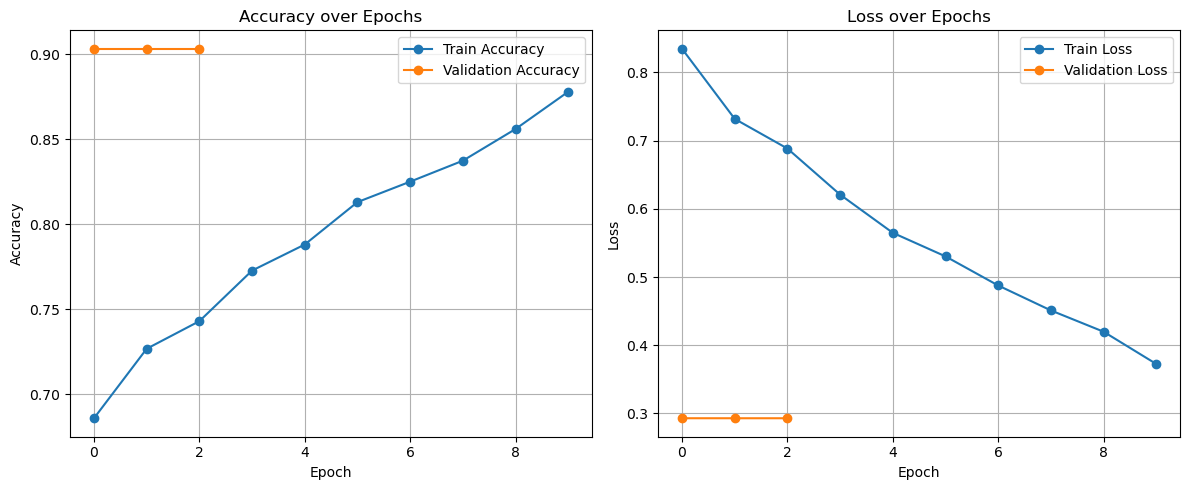

In [28]:
import matplotlib.pyplot as plt
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
